# Digitalt Spektrum

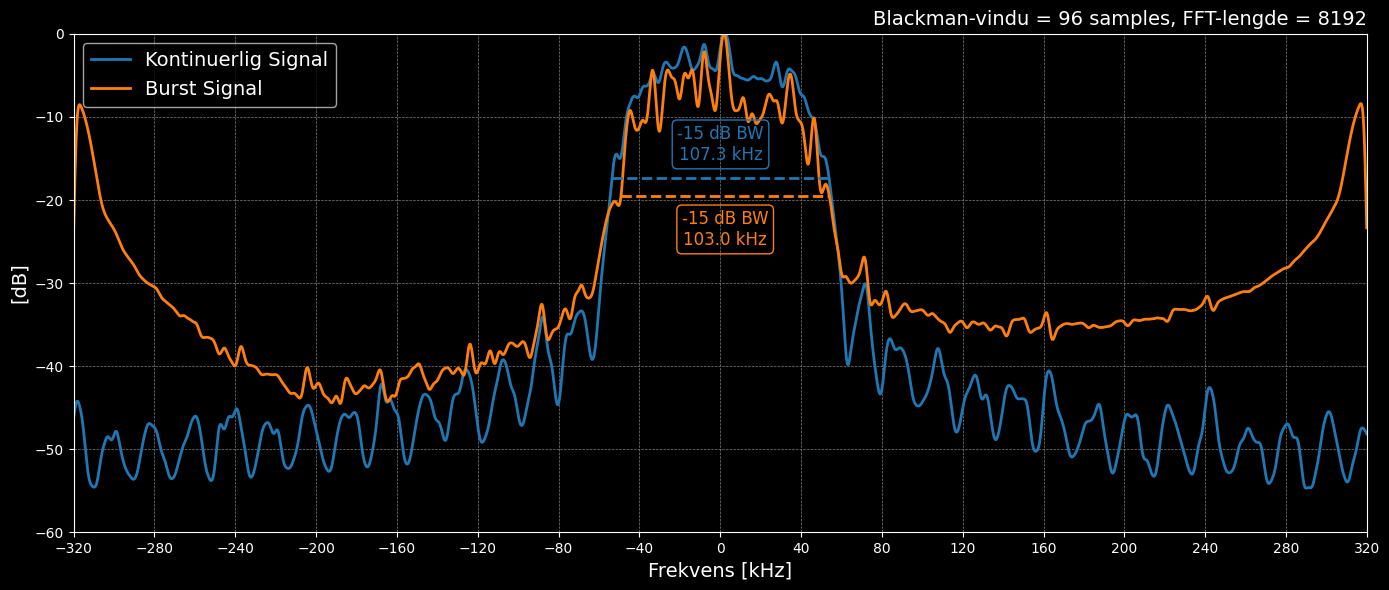

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# === PARAMETRE ===
filnavn_kont = 'SimData/TxKontData.bin'
filnavn_burst = 'SimData/TxBurstData.bin'
samp_rate = 640e3
fft_len = 8192                 # Endre for FFT-oppløsning
window_size = 96             # Glattingsvindu (antall samples)
window_func_name = 'blackman'     # Velg mellom: 'hann', 'blackman', 'hamming', 'bartlett', ...

# === VELG VINDUSFUNKSJON ===
window_functions = {
    'hann': np.hanning,
    'blackman': np.blackman,
    'hamming': np.hamming,
    'bartlett': np.bartlett
}

# Fallback hvis ukjent navn
window_func = window_functions.get(window_func_name.lower(), np.hanning)
filter_window = window_func(window_size)
filter_window /= filter_window.sum()

# === LAST INN DATA ===
kont_data = np.fromfile(filnavn_kont, dtype=np.complex64)
burst_data = np.fromfile(filnavn_burst, dtype=np.complex64)
t = np.arange(len(kont_data)) / samp_rate * 1000  # ms

# --- Funksjon for trygg log10-konvertering ---
def log_power_spectrum(spectrum):
    spectrum_magnitude = np.abs(spectrum)
    spectrum_magnitude[spectrum_magnitude == 0] = 1e-100  # Setter nullverdier til det minste positive tallet
    return 20 * np.log10(spectrum_magnitude)

# --- FFT og spektrum ---
spektrum_kont = np.fft.fftshift(np.fft.fft(kont_data, n=fft_len))
spektrum_kont_dB = log_power_spectrum(spektrum_kont)
spektrum_kont_dB = np.convolve(spektrum_kont_dB, filter_window, mode='same')
spektrum_kont_dB -= spektrum_kont_dB.max()

# --- Burst-spektrum ---
spektrum_burst = np.fft.fftshift(np.fft.fft(burst_data, n=fft_len))
spektrum_burst_dB = log_power_spectrum(spektrum_burst)
spektrum_burst_dB = np.convolve(spektrum_burst_dB, filter_window, mode='same')
spektrum_burst_dB -= spektrum_burst_dB.max()

freqs = np.fft.fftshift(np.fft.fftfreq(fft_len, 1/samp_rate)) / 1e3

# --- Båndwidth og frekvens --- 

bw_threshold = -15 # threshold bellow rolling average maximum
bws = {}
bws_threshold = {}
freqs_upper = {}
freqs_lower = {}

freq_limit = 80  # kHz
freq_mask = np.abs(freqs) <= freq_limit

# Filtrert frekvensakse
freqs_limited = freqs[freq_mask]

for signal, spectrum_dB in zip(['Kontinuerlig', 'Burst'], [spektrum_kont_dB, spektrum_burst_dB]):
    # Finn indekser for båndwidth og frekvenser mellom +- 80 kHz
    spectrum_limited = spectrum_dB[freq_mask]
    spectrum_series = pd.Series(spectrum_limited)  # Convert numpy array to pandas Series
    max_value = spectrum_series.rolling(window=200, center=True).mean().max()
    threshold = max_value + bw_threshold
    bws_threshold[signal] = threshold
    indices = np.where(spectrum_dB >= threshold)[0]
    indecies = indices[freq_mask[indices]]  # Filter indices based on frequency mask
    if len(indices) > 0:
        lower_index = indecies[0]
        upper_index = indecies[-1]
        freqs_lower[signal] = freqs[lower_index]
        freqs_upper[signal] = freqs[upper_index]
        bws[signal] = freqs_upper[signal] - freqs_lower[signal]

# === PLOTTING ===
colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(14, 6))
plt.plot(freqs, spektrum_kont_dB, color=colors[0], label='Kontinuerlig Signal', linewidth=2)
plt.plot(freqs, spektrum_burst_dB, color=colors[1], label='Burst Signal', linewidth=2)

for signal, color in zip(['Kontinuerlig', 'Burst'], colors):
    plt.plot([freqs_lower[signal], freqs_upper[signal]], [bws_threshold[signal], bws_threshold[signal]],
             color=color, linestyle='--', linewidth=2)
    if signal == 'Kontinuerlig':
        va_obj = 'bottom'
        y_obj = 1
    else:
        va_obj = 'top'
        y_obj = -1
    plt.annotate(f'{bw_threshold} dB BW\n{bws[signal]:.1f} kHz',
                 xy=((freqs_upper[signal]+freqs_lower[signal])/2, bws_threshold[signal]), xytext=(0, y_obj*10), textcoords='offset points', color=color, fontsize=12,
                 ha='center', va=va_obj, bbox=dict(boxstyle='round,pad=0.3', edgecolor=color, facecolor='none'))

plt.annotate(f'{window_func_name.title()}-vindu = {window_size} samples, FFT-lengde = {fft_len}', 
             xy=(1, 1.01), xycoords='axes fraction', fontsize=14, ha='right', va='bottom')
plt.xlabel('Frekvens [kHz]', fontsize=14)
plt.ylabel('[dB]', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.xticks(np.arange(-320, 321, 40))
plt.xlim(-320, 320)
plt.yticks(np.arange(-60, 1, 10))
plt.ylim(-60, 0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('Figurer/Tx_spektrum.pdf', bbox_inches='tight')
plt.show()

# Målt Spektrum

## Loop-back

Spektrumseffekt:
Kont: -38.71 dBW
Burst: -42.04 dBW
Kontinuerlig (Avg. VRMS):
  Nedre grense: 2.42 MHz
  Øvre grense: 2.43 MHz
  Båndbredde: 117.00 kHz
Burst (Max Hold):
  Nedre grense: 2.42 MHz
  Øvre grense: 2.43 MHz
  Båndbredde: 119.00 kHz


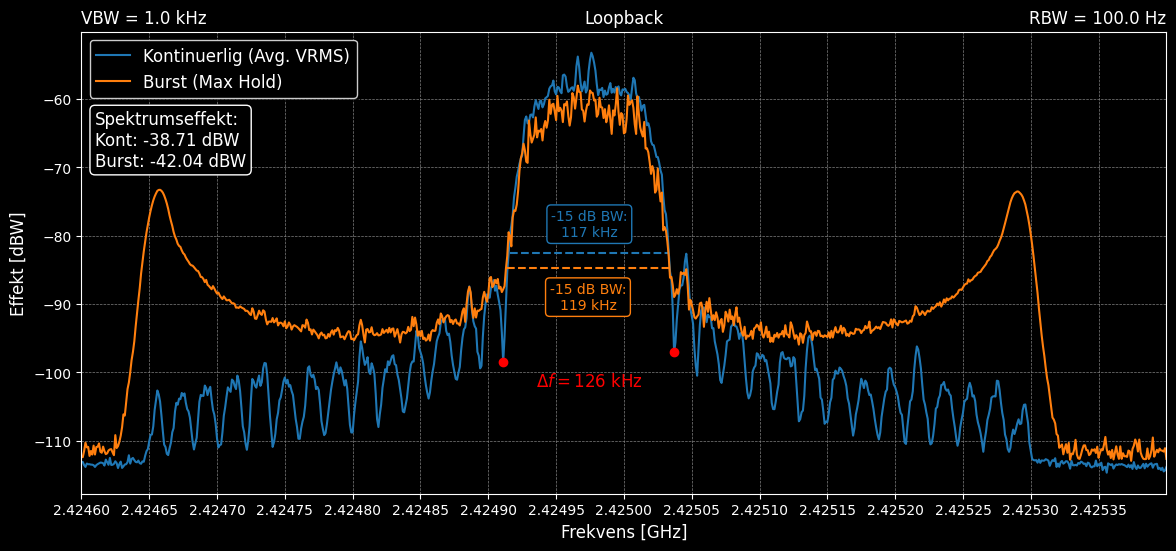

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, argrelextrema
plt.style.use('dark_background')

file_paths = [
    "Måling/KontSpektrumLoopBack.csv",
    "Måling/BurstSpektrumLoopBack.csv",]

RBW = 100 # Hz
VBW = 1000 # Hz

columns = ['Power [dBW]', 'Frequency[Hz]']
spektrum = {}
keys = ['Kontinuerlig (Avg. VRMS)', 'Burst (Max Hold)']
spektrum = {key: pd.DataFrame() for key in keys}
for file_path, key in zip(file_paths, keys):
    spektrum[key] = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)
    spektrum[key]['Frequency[GHz]'] = spektrum[key]['Frequency[Hz]'] / 1e9
    spektrum[key]['Power [dBW]'] = spektrum[key]['Power [dBW]'] + 30 # Attenuator + 30 dB

P_ut_str="Spektrumseffekt:"
temp_keys = ['Kont', 'Burst']
for key,tkey in zip(keys,temp_keys):
    utgangseffekt = 10* np.log10(np.sum(10 ** (spektrum[key]['Power [dBW]'] / 10)))
    P_ut_str += f'\n{tkey}: {utgangseffekt:.2f} dBW'

print(P_ut_str)

# --- FINN MINIMA UNDER -80 dBW I 'Kontinuerlig' SPEKTRUM ---
key0 = keys[0]
df0 = spektrum[key0]

# 1) Begrens til vindu
mask = df0['Frequency[GHz]'].between(2.42491, 2.42504)
df_win = df0[mask]

# 2) Inverter for å finne minima som peaks
inverted = -df_win['Power [dBW]']

# 3) Finn peaks i det inverterte signalet (dvs. minima under -80 dBW)
#    height=80 siden -(-80) = +80
locs, props = find_peaks(inverted, height=80)

# 4) Gå tilbake til original-indekser og plukk ut frekvens/effekt
minima_idx   = df_win.index[locs]
minima_freqs = df0.loc[minima_idx, 'Frequency[GHz]']
minima_pows  = df0.loc[minima_idx, 'Power [dBW]']

bw_threshold = -15
bws = {}
freqs_upper = {}
freqs_lower = {}
for key in keys:
    df = spektrum[key]

    # Frekvens- og effektfilter
    freq_mask = df['Frequency[GHz]'].between(2.42491, 2.42504)
    power_mask = df['Power [dBW]'] > df['Power [dBW]'].rolling(window=150,center=True).mean().max() + bw_threshold
    mask = freq_mask & power_mask

    # Øvre og nedre frekvens (i MHz)
    freqs_upper[key] = df.loc[mask, 'Frequency[GHz]'].max()
    freqs_lower[key] = df.loc[mask, 'Frequency[GHz]'].min()

    # Båndbredde i kHz
    bws[key] = (freqs_upper[key] - freqs_lower[key]) * 1e6 # allerede i MHz, så resultat blir i kHz

    print(f"{key}:")
    print(f"  Nedre grense: {freqs_lower[key]:.2f} MHz")
    print(f"  Øvre grense: {freqs_upper[key]:.2f} MHz")
    print(f"  Båndbredde: {bws[key]:.2f} kHz")

colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(14,6))
for key, color in zip(keys, colors):
    bw_yline = spektrum[key]['Power [dBW]'].rolling(window=150,center=True).mean().max()+bw_threshold
    plt.plot(spektrum[key]['Frequency[GHz]'], spektrum[key]['Power [dBW]'], linestyle='-', color=color, label=key)
    plt.plot([freqs_lower[key], freqs_upper[key]], [bw_yline, bw_yline], linestyle='--', color=color, alpha=1)
    if key == keys[0]:
        va_obj = 'bottom'
        y_obj = 1
    else:
        va_obj = 'top'
        y_obj = -1
    plt.annotate(f'{bw_threshold} dB BW:\n{bws[key]:.0f} kHz', xy=((freqs_upper[key]+freqs_lower[key])/2, bw_yline), xytext=(0, y_obj*10), textcoords='offset points',
                 fontsize=10, ha='center', va=va_obj, color=color, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='black')) 

plt.scatter(minima_freqs, minima_pows, color='red', marker='o',zorder=2)
plt.annotate(r'$\Delta f ='+f'{(minima_freqs.iloc[1]-minima_freqs.iloc[0])*1e6:.0f}$ kHz', xy=((minima_freqs.iloc[1]+minima_freqs.iloc[0])/2, minima_pows.iloc[0]), xytext=(0.5, -20), textcoords='offset points',
            fontsize=12, ha='center', va='bottom', color='red')

plt.annotate('RBW = {:.1f} Hz'.format(RBW), xy=(1, 1.01), xycoords='axes fraction', fontsize=12, ha='right', va='bottom')
plt.annotate('VBW = {:.1f} kHz'.format(VBW/1000), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left', va='bottom')
plt.annotate('Loopback', xy=(0.5, 1.01), xycoords='axes fraction', fontsize=12, ha='center', va='bottom')

plt.annotate(P_ut_str, xy=(0.0125, 0.83), xycoords='axes fraction', fontsize=12, ha='left', va='top',bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='black'))

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Effekt [dBW]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)
plt.xticks(np.arange(2.4246, 2.4254, 0.00005))
plt.xlim(2.4246, 2.4254)
plt.legend(loc='upper left', fontsize=12, shadow=True, fancybox=True)
plt.savefig('Figurer/LoopbackSpektrum.pdf', bbox_inches='tight')
plt.show()

## Antenne

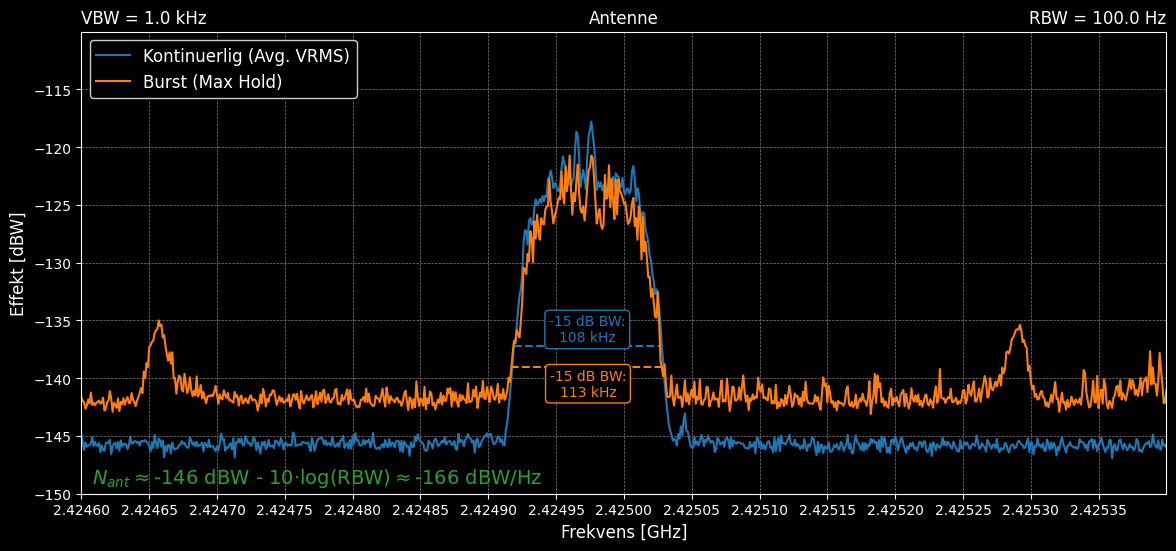

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

file_paths = [
    "Måling/KontSpektrumAntenne.csv",
    "Måling/BurstSpektrumAntenne.csv",]

RBW = 100 # Hz
VBW = 1000 # Hz

columns = ['Power [dBW]', 'Frequency[Hz]']
spektrum = {}
keys = ['Kontinuerlig (Avg. VRMS)', 'Burst (Max Hold)']
spektrum = {key: pd.DataFrame() for key in keys}
for file_path, key in zip(file_paths, keys):
    spektrum[key] = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)
    spektrum[key]['Frequency[GHz]'] = spektrum[key]['Frequency[Hz]'] / 1e9
    spektrum[key]['Power [dBW]'] = spektrum[key]['Power [dBW]']


bw_threshold = -15
bws = {}
freqs_upper = {}
freqs_lower = {}
for key in keys:
    df = spektrum[key]

    # Frekvens- og effektfilter
    freq_mask = df['Frequency[GHz]'].between(2.4248, 2.4251)
    power_mask = df['Power [dBW]'] > df['Power [dBW]'].rolling(window=50,center=True).mean().max() + bw_threshold
    mask = freq_mask & power_mask

    # Øvre og nedre frekvens (i MHz)
    freqs_upper[key] = df.loc[mask, 'Frequency[GHz]'].max()
    freqs_lower[key] = df.loc[mask, 'Frequency[GHz]'].min()

    # Båndbredde i kHz
    bws[key] = (freqs_upper[key] - freqs_lower[key]) * 1e6 # allerede i MHz, så resultat blir i kHz



colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(14,6))
for key, color in zip(keys, colors):
    bw_yline = spektrum[key]['Power [dBW]'].rolling(window=50,center=True).mean().max()+bw_threshold
    plt.plot(spektrum[key]['Frequency[GHz]'], spektrum[key]['Power [dBW]'], linestyle='-', color=color, label=key)
    plt.plot([freqs_lower[key], freqs_upper[key]], [bw_yline, bw_yline], linestyle='--', color=color, alpha=1)
    if key == keys[0]:
        va_obj = 'bottom'
        y_obj = 1
    else:
        va_obj = 'top'
        y_obj = -1
    plt.annotate(f'{bw_threshold} dB BW:\n{bws[key]:.0f} kHz', xy=((freqs_upper[key]+freqs_lower[key])/2, bw_yline), xytext=(0, y_obj*1), textcoords='offset points',
                 fontsize=10, ha='center', va=va_obj, color=color, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='black')) 

plt.annotate(r'$N_{ant}\approx$-146 dBW - 10$\cdot$log(RBW)$\approx$-166 dBW/Hz', xy=(0.01, 0.01), xycoords='axes fraction', fontsize=14, ha='left', va='bottom',color='tab:green')

plt.annotate('RBW = {:.1f} Hz'.format(RBW), xy=(1, 1.01), xycoords='axes fraction', fontsize=12, ha='right', va='bottom')
plt.annotate('VBW = {:.1f} kHz'.format(VBW/1000), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left', va='bottom')
plt.annotate('Antenne', xy=(0.5, 1.01), xycoords='axes fraction', fontsize=12, ha='center', va='bottom')
plt.xticks(np.arange(2.4246, 2.4254, 0.00005))
plt.xlim(2.4246, 2.4254)
plt.yticks(np.arange(-150, -110, 5))
plt.ylim(-150, -110)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Effekt [dBW]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)
plt.legend(loc='upper left', fontsize=12, shadow=True, fancybox=True)
plt.savefig('Figurer/AntenneSpektrum.pdf', bbox_inches='tight')
plt.show()

# Sinus Loopback

Peak offset: 5.50 kHz
Maximum power: -35.63 dBW
Maximum frequency: 2424984500.000000 GHz


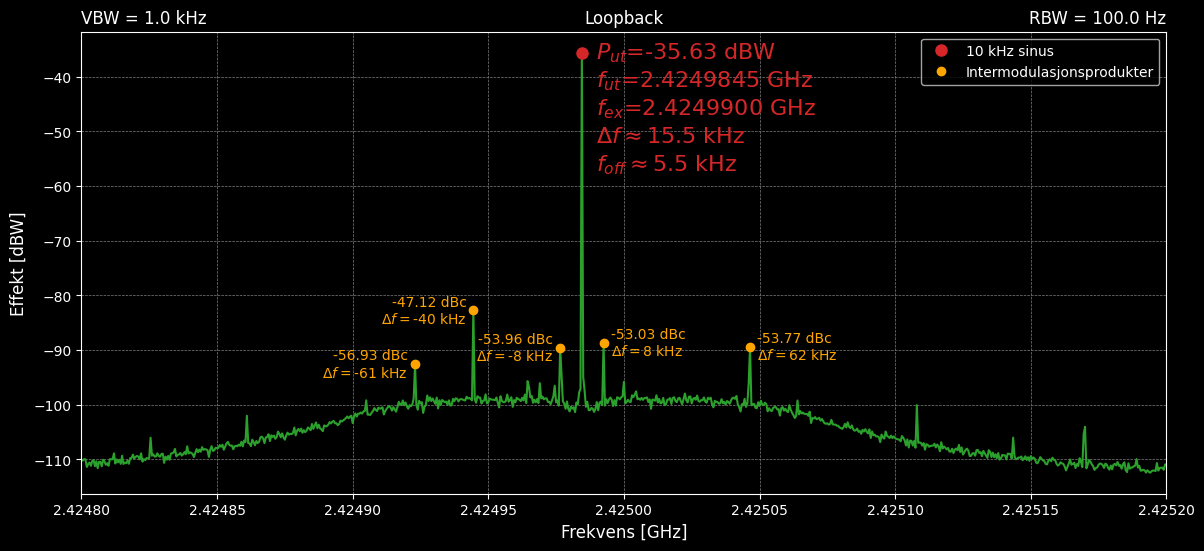

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
plt.style.use('dark_background')

filnavn = "Måling/Sinus10kHz.csv"
RBW = 100  # Hz
VBW = 1000  # Hz

columns = ['Power [dBW]', 'Frequency[Hz]']
spektrum = pd.read_csv(filnavn, sep=',', names=columns, skiprows=154)
spektrum['Frequency[GHz]'] = spektrum['Frequency[Hz]'] / 1e9
spektrum['Power [dBW]'] = spektrum['Power [dBW]'] + 30  # Attenuator + 30 dB

# Finn hovedtoppen
max_power = spektrum['Power [dBW]'].max()
max_power_index = spektrum['Power [dBW]'].idxmax()
max_freq = spektrum['Frequency[Hz]'][max_power_index]

# Peak offset
f_c = 2.425e9
f_expected = f_c - 10e3
peak_offset = np.abs(max_freq - f_expected) / 1e3
print(f'Peak offset: {peak_offset:.2f} kHz')
print(f'Maximum power: {max_power:.2f} dBW')
print(f'Maximum frequency: {max_freq:.6f} GHz')

# Finn alle topper
peaks, _ = find_peaks(spektrum['Power [dBW]'], height=-95)  # juster høyde om nødvendig
peaks_freqs = spektrum['Frequency[GHz]'].iloc[peaks]
peaks_powers = spektrum['Power [dBW]'].iloc[peaks]

# Fjern hovedtoppen fra lista (vi har allerede markert den rødt)
peak_freqs_other = peaks_freqs[peaks_freqs != max_freq / 1e9]
peak_powers_other = peaks_powers[peaks_freqs != max_freq / 1e9]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(spektrum['Frequency[GHz]'], spektrum['Power [dBW]'], linestyle='-', color='tab:green')
plt.plot(max_freq / 1e9, max_power, 'o', color="tab:red", markersize=8, label='10 kHz sinus')
plt.plot(peak_freqs_other, peak_powers_other, 'o', color="orange", markersize=6, label='Intermodulasjonsprodukter')
for power, freq in zip(peak_powers_other, peak_freqs_other):
    delta_f_kHz = (freq - max_freq / 1e9) * 1e6  # fra GHz til kHz
    delta_P = power- max_power
    if delta_f_kHz < 0:
        ha_str="right"
        x_cord = -5
    else:
        ha_str="left"
        x_cord=5
    plt.annotate(f'{delta_P:.2f} dBc\n'+r'$\Delta f=$'+f'{delta_f_kHz:.0f} kHz', 
                 xy=(freq, power), 
                 xytext=(x_cord, 0), 
                 textcoords='offset points', 
                 color="orange", 
                 fontsize=10, 
                 ha=ha_str, 
                 va='center')

plt.annotate(r'$P_{ut}$=' + f'{max_power:.2f} dBW', xy=(max_freq / 1e9, max_power), xytext=(10, 0), textcoords='offset points', color="tab:red", fontsize=16, ha='left', va='center')
plt.annotate(r'$f_{ut}$=' + f'{max_freq/1e9:.7f} GHz', xy=(max_freq / 1e9, max_power), xytext=(10, -20), textcoords='offset points', color="tab:red", fontsize=16, ha='left', va='center')
plt.annotate(r'$f_{ex}$=' + f'{f_expected/1e9:.7f} GHz', xy=(max_freq / 1e9, max_power), xytext=(10, -40), textcoords='offset points', color="tab:red", fontsize=16, ha='left', va='center')
plt.annotate(r'$\Delta f\approx$' + f'{(f_c-max_freq)/1e3:.1f} kHz', xy=(max_freq / 1e9, max_power), xytext=(10, -60), textcoords='offset points', color="tab:red", fontsize=16, ha='left', va='center')
plt.annotate(r'$f_{off}\approx$' + f'{peak_offset:.1f} kHz', xy=(max_freq / 1e9, max_power), xytext=(10, -80), textcoords='offset points', color="tab:red", fontsize=16, ha='left', va='center')

plt.annotate('RBW = {:.1f} Hz'.format(RBW), xy=(1, 1.01), xycoords='axes fraction', fontsize=12, ha='right', va='bottom')
plt.annotate('VBW = {:.1f} kHz'.format(VBW / 1000), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left', va='bottom')
plt.annotate('Loopback', xy=(0.5, 1.01), xycoords='axes fraction', fontsize=12, ha='center', va='bottom')
plt.xlim(2.4248, 2.4252)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Effekt [dBW]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)
plt.legend()
plt.savefig('Figurer/Sinus10kHz.pdf', bbox_inches='tight')
plt.show()
